# Description
- preprocessing.intersect_time(): Fix the problem if the time intersection of predictand and predictor has shape (0,) (done)
    - Delete timepoints from predictor series if not in predictand timeseries (done)
- Check rf008.py again if Y=Y[0] is correct (line 136)
    - Done: Its fine because the predictand values are the same (GESLA-DS) for all predictors as long as the timeseries t is the same.
- Preprocessing: Convert timedata from era5 dataset 2019-2022 to numpy.datetime64 type. (done)
    - Update DataArray with converted np.array of timepoints. (done)
    - Update dataloader of predictor to check for type of timepoint entries. (done)
    - Check deletion of timepoints when intersecting the timeseries of predictor and predictand. (done)
- Check how good model works on unseen data. (done)
- Now a combination of timelag and predictors is possible
    - Make sure to interpret the importance map correctly though! Check the way separate_predictor_importance orders the 
    predictors and timelags carefully!

# Working Area

In [1]:
# Modules
import numpy as np
import xarray as xr
import pandas as pd
import pickle
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler


from data import data_loader
from data import gesla_preprocessing
from data import era5_preprocessing
from data import preprocessing
from data import saver

from models import modelfit
from models import evaluation
from models import loader

In [20]:
#--- 
# List of modelruns that where promising
# rf001: Using sp only (no timelag)
# rf002: Using sp only (no timelag)
# rf003: No improvement (RandomSearch was used)
# rf004: Best combinations: All predictors or (tp, u10) but rf008 shows, that after scaling no combination works well
# rf005: sp only, timelag of 3 or u10 only, timelag of 3
# rf006: u10 with combined timelags 2 and 3 has highest tpr=80%
#---
best_models = [
    "models/random_forest/rf004/rf004RandomSearchCV_3.sav", # rf004, (tp, u10)
    "models/random_forest/rf005/rf005RandomSearchCV_2.sav", # rf005 (sp timelag3)
    "models/random_forest/rf005/rf005RandomSearchCV_12.sav", # rf005 (u10 timelag3)
    "models/random_forest/rf006/rf006RandomSearchCV_14.sav", # rf006 u10 with timelags 2 and 3
    ]

#---
# Import model
#---
model = loader.load_model(best_models[3])
print(type(model))
print(model)

<class 'sklearn.ensemble._forest.RandomForestClassifier'>
RandomForestClassifier(class_weight='balanced', max_depth=5, min_samples_leaf=2,
                       n_estimators=777, oob_score=True, random_state=0)


In [21]:
#---
# Load data 
#  
#---
# Get timeseries of predictor and predictand
model_run = "rf009"
preprocess = "preprocess1" # ["preprocess1"]
range_of_years = "2009-2018" # ["1999-2008", "2009-2018", "2019-2022",] 
subregion = "lon-0530_lat7040" # ["lon-0530_lat7040"]
season = "winter" # ["winter", "autumn",] 
percentile = 0.95 # [0.95, 0.99,] 
station_names = ["hanko-han-fin-cmems",]

#---
# Preprocess GESLA Data
#---

# Load Predictand
#---
gesla_predictand = data_loader.load_gesla(station_names)

# Select a season
#---
gesla_predictand = gesla_preprocessing.select_season(gesla_predictand, season)

# Select only sea_level analysis data
#---
gesla_predictand = gesla_preprocessing.get_analysis(gesla_predictand)

# Subtract mean of data grouped by station
#---
gesla_predictand = gesla_predictand["sea_level"] # Detrend expects pd.Series
gesla_predictand = gesla_preprocessing.detrend(gesla_predictand, level="station")

# Apply one hot encoding
gesla_predictand = gesla_preprocessing.apply_dummies(gesla_predictand, percentile=percentile, level="station")
print(f"Applied one-hot-encoding with Percentile: {percentile}")

# Convert to DataArray
# nan values: no measurement at that timestamp for specific station
gesla_predictand = gesla_predictand.to_xarray()

Load Predictand from GESLA
Applied one-hot-encoding with Percentile: 0.95


In [24]:
#---
# TODO:
#   - Check if a combination of predictors and a timelag for each one is possible (yes)
#       - Seems to work (rf004 cfm showed same results) but check with further models
#   - Make sure to check how the importance map is then separated as there is one dimension more now (time, timelag, npred, lon, lat) compared to before
# (time, npred, lon, lat)
#---
X = []
Y = []
t = []
predictors = [
    # "sp",
    # "tp", 
    "u10",
    # "v10",
]
timelags = [
    # 0,
    # 1,
    2,
    3,
]

for predictor in predictors:
    print(f"Add predictor {predictor} to model input features")

    era5_predictor = data_loader.load_daymean_era5(range_of_years, subregion, season, predictor, preprocess)
    era5_predictor = preprocessing.convert_timestamp(era5_predictor, dim="time")
    X_, Y_, t_ = preprocessing.intersect_time(era5_predictor, gesla_predictand)
    print(f"Introduce timelags: {timelags}")
    X_timelag, Y_timelag = preprocessing.combine_timelags(X_, Y_, timelags)
    print(Y_timelag.shape)

    X.append(X_timelag)
    Y.append(Y_timelag)
    t.append(t_)

X = np.array(X)
Y = np.array(Y) 
Y = Y[0, :] # Assume all timeseries are the same for the predictors.
t = np.array(t)

# Reshape for model input
#---
print(f"Reshape for model input")

ndim = Y.shape[0]

X = X.swapaxes(0, 2)

print(X.shape) # (time, timelags, predictor_combination, lon?, lat?)

X = X.reshape(ndim, -1) # Reshapes into (time, timelag1pred1_lonlats:timelag1pred2_lonlats:...:timelag1predn_lonlats:timelag2pred1_lonlats,...:timelagnpredn_lonlats)
y = Y[:, 0] # Select one station

#---
# Handle NaN Values
#---

# Insert numerical value that is not in data.
# ML will hopefully recognize it.
X[np.where(np.isnan(X))] = -999

print("Data is prepared as follows")
print(f"X.shape : {X.shape}")
print(f"y.shape : {y.shape}")

Add predictor u10 to model input features
timeseries is already of dtype datetime64[ns]
Get overlapping timeseries of ERA5 and GESLA
date:2016-01-01 at position [631] was deleted as it was in predictor data but not in predictand data
date:2016-01-02 at position [631] was deleted as it was in predictor data but not in predictand data
date:2016-01-03 at position [631] was deleted as it was in predictor data but not in predictand data
Introduce timelags: [2, 3]
(896, 1)
Reshape for model input
(896, 2, 1, 121, 141)
Data is prepared as follows
X.shape : (896, 34122)
y.shape : (896,)


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, test_size=0.25)

Show Confusion Matrix on testdata 



C:\Users\Kai\AppData\Local\Temp\ipykernel_15256\944544885.py:10: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  cfm_fig1.show()


saved cf matrix to : results/random_forest/rf009/cf_matrix_95_3.pdf
Metric values 

tnr: 0.9026442307692307
tpr: 0.296875
gmean: 0.5176606089027977
wacc: 0.5997596153846154
precision: 0.19
recall: 0.296875
fmeasure: 0.23170731707317072
{'tnr': 0.9026442307692307, 'tpr': 0.296875, 'gmean': 0.5176606089027977, 'wacc': 0.5997596153846154, 'precision': 0.19, 'recall': 0.296875, 'fmeasure': 0.23170731707317072}


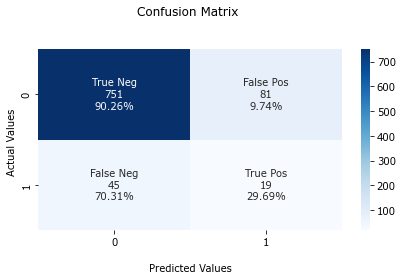

In [ ]:
#---
# Evaluate Prediction
#---
folder = "results/random_forest/rf009/"
saver.directory_existance(folder)

print("Show Confusion Matrix on testdata \n")
cfm_fig1 = evaluation.plot_cf(model, X, y)
cfm_fig1.show()

# # Save CFM
# fname = f"{folder}cf_matrix_{str(percentile)[-2:]}_{run_id}.pdf"
# cfm_fig1.savefig(fname)
# print(f"saved cf matrix to : {fname}")

# # Calculate CFM-Metrics
# metrics1 = evaluation.cfm_metrics(model, X, y)
# print(metrics1)
# fname = f"cf_metrics_{str(percentile)[-2:]}_{run_id}.pkl"
# with open(f"{folder}{fname}", 'wb') as f:
#     pickle.dump(metrics1, f)

In [ ]:
#---
# Plot Predictor-Map at position where y = 1 and indicate whether y_pred is 0 or 1
#---

In [ ]:
#---
# IMPORTANT TO KNOW.
# Check how np.reshape flattens the array
#---
arr = np.random.random((3,2,2,3,4)) # (time, timelag, pred, lon?, lat?)
flat_arr = arr.reshape(3, -1)

print(arr)
print(arr.shape)
print(arr[1, 1, 1, :, :])
print(flat_arr[0, 0:12]) # First flattened lon lat values, e.g first timelag, first predictor
print(flat_arr[0, 12:24]) # Second flattened lon lat, e.g. first timelag, second predictor
print(flat_arr[0, 24:36]) # Third, e.g. second timelag, first predictor
print(flat_arr[1, 36:48])


[[[[[6.30346320e-01 8.87075075e-01 5.92364535e-01 6.90815878e-01]
    [6.70947643e-01 1.34226635e-02 4.67200984e-01 5.58050967e-01]
    [6.14475675e-04 4.79518084e-01 8.37976738e-01 9.37026858e-01]]

   [[1.67908196e-01 5.22825354e-01 4.15334102e-01 9.04240062e-01]
    [4.43848803e-01 4.49547396e-01 1.44400046e-02 3.45535069e-01]
    [1.36589633e-01 1.06135960e-01 6.92002319e-01 1.61738268e-01]]]


  [[[4.36834334e-01 6.94431033e-01 8.27496791e-01 2.31805335e-01]
    [2.71197110e-01 5.02637438e-01 2.65473376e-01 5.94617616e-01]
    [6.03974367e-01 7.28811243e-01 1.64128757e-01 3.06205497e-01]]

   [[7.31446910e-01 6.99555840e-01 8.02583325e-01 3.20935309e-01]
    [6.20563000e-01 9.25573683e-01 8.89674979e-01 9.07130204e-01]
    [7.24836036e-01 6.01569663e-01 3.72535270e-01 3.69909625e-01]]]]



 [[[[9.69916879e-01 1.14399448e-01 4.43277381e-01 4.51991268e-01]
    [7.24941031e-01 2.09741520e-01 2.25735371e-01 5.67297339e-01]
    [4.39424606e-01 5.83410224e-02 8.44201375e-01 9.59157871e-

In [74]:
#---
# Check out GESLA Dataset timepoints
# GESLA Dataset only goes until 2020 and only December of that year is covered
#---
predictand_time = pd.to_datetime(gesla_predictand.date_time.values).date
year_idx = gesla_predictand.date_time.groupby("date_time.year").groups
month_idx = gesla_predictand.date_time.groupby("date_time.month").groups
print(f"Years in GESLA Dataset: {year_idx.keys()}")
print(f"Month in GESLA Dataset: {month_idx.keys()}")

# Check if certain month is in dataset for a specific year
#---
sel_month = month_idx[1]
sel_year = year_idx[2020]
inters = np.intersect1d(sel_month, sel_year) # If inters is empty, no data of that month in indicated year is in dataset
inters.shape

Years in GESLA Dataset: dict_keys([1971, 1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020])
Month in GESLA Dataset: dict_keys([1, 2, 12])


(0,)

In [137]:
def convert_timestamp(da, dim):
    """
    Description: 
        Converts timepoint to datetime64 type
    Parameters:
        da (DataArray): DataArray with timeseries
        dim (str): Flag of time dimension
    Return:
        da (DataArray): DataArray with converted timestamp values
    """
    # Ensure correct dtype of timestamp
    #---
    if da[dim].dtype == "float64":
        print(f"convert timestamp from dtype: {da[dim].dtype} to datetime64")
        era5_timeflag = "T11:30:00.000000000" # Timeflag of ERA5
        t = da[dim].values 
        t_datetime = preprocessing.float64_to_datetime64(t, era5_timeflag) # Convert datatype 
        coords_to_replace = {"time" : t_datetime} 
        da = preprocessing.replace_coords(da, coords_to_replace) # Replace dimension values with new datatype
        
    if "datetime64" in str(era5_predictor["time"].dtype):
        print(f"timeseries is already of dtype {da[dim].dtype}")

    return da

In [129]:
def aggregate_dimension(da, dim):
    """
    Description:
        Aggregate (mean) along a dimension of a dataset. 
    Parameters:
        da (DataArray): xr.DataArray 
        dim (str): Dimension along which mean is taken
    Return:
        aggregated_da
    """
    aggregated_da = da.mean(dim=dim)
    
    return aggregated_da

In [8]:
#---
# Convert np.float64 to np.Datetime64
#---
def float64_to_datetime64(t, timeflag=""):
    """
    Description: 
        Converts dates of type float64, e.g. (yyyymmdd.0) into datetime64 format.
    Parameters:
        t (np.array, float64): Values of timeseries to be converted
        timeflag (str): Timeflag of specific hours of measurement, e.g. T11:30:00.000000000.
    Returns:
        t_datetime (np.array, np.datetime64): Converted values of timeseries
    """
    #- Modules
    import numpy as np

    #- Init
    t_datetime = []

    #- Main
    for timepoint in t: 
        timepoint = str(int(timepoint))
        yyyy = timepoint[:4]
        mm = timepoint[4:6]
        dd = timepoint[6:8]
        new_date = np.datetime64(f"{yyyy}-{mm}-{dd}{timeflag}")
        t_datetime.append(new_date)

    t_datetime = np.array(t_datetime)

    return t_datetime

In [9]:
#---
# Update DataArray with timepoints
#---
def replace_coords(da, coords_to_replace):
    """
    Description:
        Replaces indicated dimensions (keys) in dims_to_replace with corresponding values.
        Leaves name of dimension unchanged.
    Parameters:
        da (xr.DataArray): DataArray with coordinates and values to replace
        coords_to_replace (dict): Dictionary with coordinates as keys and new values to replace old ones with.
    Returns:
        da (xr.DataArray): DataArray with updated coordinate values
    """
    for coord, values in coords_to_replace.items():
        da.coords[coord] = values
        
    return da

In [77]:
gesla_predictand.sel(date_time=gesla_predictand.date_time.dt.year.isin([2016]))
# gesla_predictand.sel(time=gesla_predictand.date_time.dt.month.isin([6, 7, 8]))

<xarray.DataArray 'sea_level' (station: 1, date_time: 2105)>
array([[0., 0., 0., ..., 0., 0., 0.]])
Coordinates:
  * station    (station) int64 0
  * date_time  (date_time) datetime64[ns] 2016-01-04T06:00:00 ... 2016-12-31T...